# Spectra Example Workbook

**Question:** Given absorbance spectra of chemical A and chemical B, can we calculate the ratio of a mixture of chemical A + B?

**Note:** A final answer will assume that the concentration of the chemical is related **linearly** to its absorbance of light. Is this a valid assumption? **Calibration absorption curves** generated from samples of known concentration would show whether this is the case or not; this would be a job for the chemists.

## Packages imported here

In [46]:
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Work starts here

### Initial data import and exploratory analysis

In [12]:
# Read absorption data into Python with Pandas
chem_a = pd.read_excel("RingIR_Example_ChemicalMixture[87].xlsx", 
                        sheet_name = "Chemical A")
chem_b = pd.read_excel("RingIR_Example_ChemicalMixture[87].xlsx",
                        sheet_name = "Chemical B")
chem_mix = pd.read_excel("RingIR_Example_ChemicalMixture[87].xlsx",
                        sheet_name = "Chemical A + B")

In [17]:
# Check how the data has been read into the dataframes
chem_a.head(), chem_b.head(), chem_mix.head()

(   Wavelength  Absorbance
 0           1    0.000152
 1           2    0.000152
 2           3    0.000152
 3           4    0.000153
 4           5    0.000153,
    Wavelength  Absorbance
 0           1    0.000729
 1           2    0.000722
 2           3    0.000715
 3           4    0.000708
 4           5    0.000702,
    Wavelength  Absorbance
 0           1    0.001226
 1           2    0.001222
 2           3    0.001218
 3           4    0.001214
 4           5    0.001210)

In [18]:
# Check sizes of data to make sure same wavelength ranges were scanned for 
#  all 3 experiments.
chem_a.size, chem_b.size, chem_mix.size

(80108, 80108, 80108)

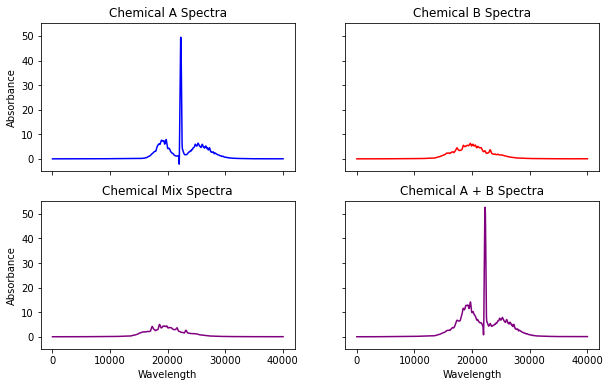

In [72]:
def plot_spectra(chem_a, chem_b, chem_mix, column="Absorbance"):
    
    """
    Plot individual absorption spectra and one spectra where A and B are added.
    These are plotted on the same x and y axes to better show relative 
    absorbances across all spectra.
    """

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, 
                       sharey=True, figsize=(10,6))

    ax[0,0].plot(chem_a["Wavelength"], chem_a[column], 'b')
    ax[0,0].set_title("Chemical A Spectra")
    ax[0,0].set_ylabel("Absorbance")

    ax[0,1].plot(chem_b["Wavelength"], chem_b[column], 'r')
    ax[0,1].set_title("Chemical B Spectra")

    ax[1,0].plot(chem_mix["Wavelength"], chem_mix[column], 'purple')
    ax[1,0].set_title("Chemical Mix Spectra")
    ax[1,0].set_xlabel("Wavelength")
    ax[1,0].set_ylabel("Absorbance")

    ax[1,1].plot(chem_a["Wavelength"],
                  chem_a[column] + chem_b[column], 'purple')
    ax[1,1].set_title("Chemical A + B Spectra")
    ax[1,1].set_xlabel("Wavelength");
    
plot_spectra(chem_a, chem_b, chem_mix)

From the plots given above, two aspects must be addressed before we consider any analysis of analyte concentration ratios:
- Normalization of the spectra, to take into account differences in emission strength of the machine.
- Potential problem: Is the spectra for Chemical A negative near the large peak? What should be done with this?

We'll look at these problems one at a time

**Normalization**

In [64]:
def norm_spectra(chem):
    """
    Normalize absorbance spectra and add as new column in dataframe.
    """
    summation = chem["Absorbance"].sum(axis=0)
    chem["Norm. Absorbance"] = chem["Absorbance"]/summation
    
# Apply this new function to the respective spectra
norm_spectra(chem_a)
norm_spectra(chem_b)
norm_spectra(chem_mix)

# Make sure function manipulates the dataframe as expected
chem_a.head(), chem_b.head(), chem_mix.head()

(   Wavelength  Absorbance  Norm. Absorbance
 0           1    0.000152      2.495387e-09
 1           2    0.000152      2.500504e-09
 2           3    0.000152      2.505728e-09
 3           4    0.000153      2.511059e-09
 4           5    0.000153      2.516496e-09,
    Wavelength  Absorbance  Norm. Absorbance
 0           1    0.000729      1.789979e-08
 1           2    0.000722      1.772725e-08
 2           3    0.000715      1.755711e-08
 3           4    0.000708      1.738935e-08
 4           5    0.000702      1.722396e-08,
    Wavelength  Absorbance  Norm. Absorbance
 0           1    0.001226      4.000589e-08
 1           2    0.001222      3.987129e-08
 2           3    0.001218      3.973826e-08
 3           4    0.001214      3.960679e-08
 4           5    0.001210      3.947689e-08)

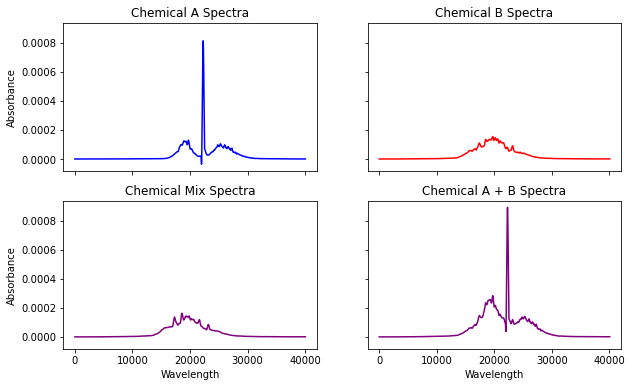

In [73]:
# Plot the spectra once more
plot_spectra(chem_a, chem_b, chem_mix, column="Norm. Absorbance")

**Negative absorbances**

Why is the absorbance negative in chemical A? Questions to ask chemists:
- Is the measuring instrument single or double beam? Absorbances could be negative according to $A_{measured} = A_{sample} - A_{blank}$, where $A_{blank}$ is the absorbance of a blank sample.
- Are there fluorescent impurities in chemical A that could emit additional light?

At this stage, we are _**not**_ going to pursue removal of the negative values to avoid introducing discontinuities in the spectra. Discontinuities may result in spurious peaks when we apply a continuous wavelet transform.

**Summary from exploratory analysis**

As it stands now, from a purely visual standpoint, the spectra of the mixture appears to be very similar to the spectra for chemical B, _provided that the spectra for chemical A is without error or impurities_. Thus far, the hypothesis is the following: **The chemical mixture is predominately chemical B with (possible) trace amounts of chemical A**. 

We now pursue more quantitative methods to find a numerical ratio and determine whether our initial assessment is correct.

### Focused quantitative analysis

**Basic mathematical idea**

Supposing our mixture is predominately a binary mixture, we employ a continuous wavelet transform and study the "zero" crossings. The mathematical idea is that, assuming a mixture of two analytes whose absorbance is measured at a wavelength $\lambda$, the corresponding absorbance of the binary mixture is (see: Charlotte Grinter, H., and Threlfall, T. L. (1992). _UV-VIS Spectroscopy and its Applications_)

$ A_{mix}(\lambda) = C_{A}\alpha_{A}(\lambda) + C_{B}\alpha_{B}(\lambda)$,

where $\alpha_{i}(\lambda)$ is the absorptivity for the $i$th analyte at wavelength $\lambda$ and $C_{i}$ is the corresponding concentration of the $i$th analyte in the mix.

Applying a continuous wavelet transform (CWT) for wavelet shifting parameter (i.e. translation) $a$ and scaling parameter (i.e. dilation) $b$, the above equation becomes

$ \psi_{(a,b), mix}(\lambda) = C_{A} \psi_{(a,b), A}(\lambda)+ C_{B}\psi_{(a,b), B}(\lambda)$,

for wavelet coefficients $\psi_{(a,b)}(\lambda)$. Note that only functions dependent on $\lambda$ will be transformed and constants, such as the analyte concentration, will stay the same.

Upon generating individual continuous wavelet spectra for a given $(a,b)$, we solve for the "zero" crossings $\psi_{(a,b), A}(\lambda_{0}) = 0$ for $\lambda_{0}$, which simplifies the previous equation to

$\psi_{(a,b), mix}(\lambda_0) = \psi_{(a,b), B}(\lambda_0) C_B$,

provided the term on the right hand side does not vanish as well.

The important result is that $C_B = \psi_{(a,b), mix}(\lambda_0) / \psi_{(a,b), B}(\lambda_0)$ and is therefore independent of $C_A$ and its associated absorbance curve. 

To find the ratio of analyte concentrations, we must calculate the following expression

$\frac{C_A}{C_B} = \frac{\psi_{(a,b), mix}(\lambda_0)}{\psi_{(a,b), A}(\lambda_0)}\frac{\psi_{(a,b), B}(\lambda_1)}{\psi_{(a,b), mix}(\lambda_1)}$,

where $\lambda_0$ satisfies $\psi_{(a,b), A}(\lambda_{0}) = 0$ and $\lambda_1$ satisfies $\psi_{(a,b), B}(\lambda_{1}) = 0$.

### Continuous wavelet transform of spectra

In [100]:
# Define function to generate continuous wave transforms
def wavelet_spectra(chem, column="Norm. Absorbance", wavelet=signal.ricker,
                   width_max=101):
    """
    Generate a wavelet transform of an absorption spectra, using the Ricker 
    or "Mexican-hat" wavelet as the mother wavelet, for a range of wavelet 
    widths. 
    """
    return signal.cwt(chem[column], wavelet, widths=np.arange(1, width_max))

In [101]:
cwt_a = wavelet_spectra(chem_a)
cwt_b = wavelet_spectra(chem_b)
cwt_mix = wavelet_spectra(chem_mix)

In [115]:
# Define function to generate Ricker wavelet spectrograms for each spectra
def wavelet_spectrogram(cwt_a, cwt_b, cwt_mix, width_max=101):
    """
    Plot a set of spectrograms given continuous wavlet transformed data
    """
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False,
                           figsize=(6,10))
    
    img_a = ax[0].pcolormesh(chem_a["Wavelength"], np.arange(1,width_max), 
                             cwt_a, shading='gouraud')
    ax[0].set_ylabel("Ricker Wavelet Width")
    ax[0].set_title("CWT Spectrogram for Sample A")
    
    img_b = ax[1].pcolormesh(chem_b["Wavelength"], np.arange(1,width_max), 
                             cwt_b, shading='gouraud')
    ax[1].set_ylabel("Ricker Wavelet Width")
    ax[1].set_title("CWT Spectrogram for Sample B")
    
    img_mix = ax[2].pcolormesh(chem_mix["Wavelength"], np.arange(1,width_max), 
                     cwt_mix, shading='gouraud')
    ax[2].set_xlabel("Wavelength")
    ax[2].set_ylabel("Ricker Wavelet Width")
    ax[2].set_title("CWT Spectrogram for Sample B")

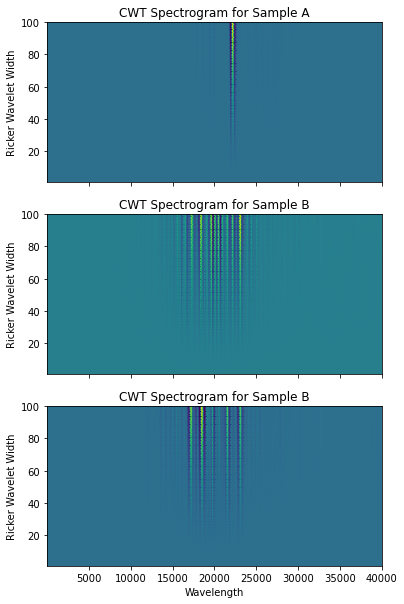

In [116]:
wavelet_spectrogram(cwt_a, cwt_b, cwt_mix, width_max=101)

From the plot above, we note that a Ricker wavelet width of 60 corresponds to oscillations of the spectrum with respect to the wavelength, so we start here to find zero crossings.

In [124]:
# Extract continuous wavelet transforms of Ricker wavelet width 60 from the 
#  full spectrogram.
cwt_a_1d = cwt_a[59,:]
cwt_b_1d = cwt_b[59,:]
cwt_mix_1d = cwt_mix[59,:]

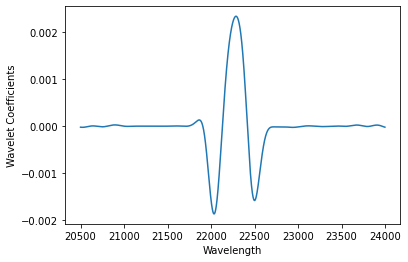

In [152]:
# Visualize these, but within the wavelength region of 20,500-24,000,
# as the majority of the interesting (i.e. non-noise) absorbance is there
plt.plot(np.arange(20500,24000),cwt_a_1d[20500:24000])
plt.xlabel("Wavelength")
plt.ylabel("Wavelet Coefficients");

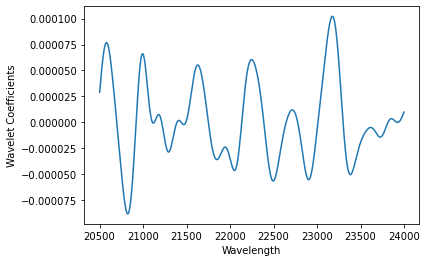

In [180]:
plt.plot(np.arange(20500,24000),cwt_b_1d[20500:24000])
plt.xlabel("Wavelength")
plt.ylabel("Wavelet Coefficients");

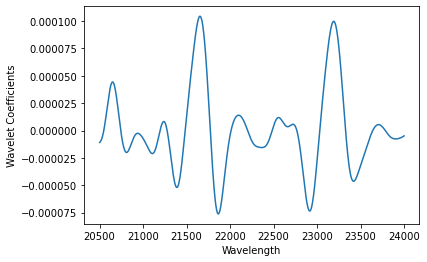

In [154]:
plt.plot(np.arange(20500,24000),cwt_mix_1d[20500:24000])
plt.xlabel("Wavelength")
plt.ylabel("Wavelet Coefficients");

### Finding the zero crosses

The goal is to now find the zeros of the respective wavelet transforms of chemical spectra A and B. Given that this is numerical data, it is unreasonable to expect that the data will be zero exactly, so it is sufficient to find the wavelength for where the wavelet coefficient curve changes sign within a given tolerance. 

In [287]:
def zero_finder(cwt_1d,lbracket, rbracket, tolerance=10**-5):
    """
    A simple root finder that finds the index where the wavelet coefficients
    are less than a certain tolerance.
    """
    roots = np.argwhere(abs(cwt_1d[lbracket: rbracket]) < tolerance)
    zero_index=[]
    for i in np.arange(len(roots)):
        # Extract the indices into a new list and add lbracket so that the 
        #  the indices correspond to the wavelength of the full spectrum
        zero_index.append(int(roots[i][0] + lbracket))
    return zero_index

In [288]:
a_roots = zero_finder(cwt_a_1d, 15000, 30000, tolerance=10**-8)

# Compare result of function with actual values of coefficients
a_roots, cwt_a_1d[a_roots]

([15083,
  15084,
  15242,
  15243,
  15478,
  15622,
  15875,
  15954,
  16131,
  16619,
  20444,
  21565,
  23958],
 array([-5.37634165e-09,  2.58974064e-09,  5.32722812e-09, -3.98042337e-09,
        -1.32891041e-09,  8.53595564e-09, -1.94558558e-09, -1.06212036e-10,
         3.93636789e-09, -7.99431242e-09,  9.85563215e-09, -4.90975052e-09,
        -2.03994186e-09]))

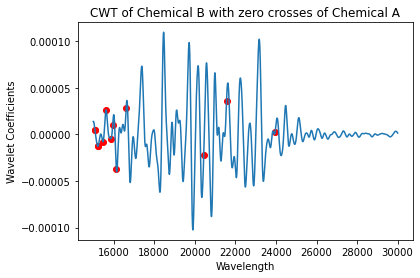

In [339]:
# Plot these on the continuous wavelet coefficient curve for Chemical B to 
#  make sure its corresponding coefficients are not zero either.
plt.plot(np.arange(15000,30000), cwt_b_1d[15000:30000])
plt.scatter(a_roots, cwt_b_1d[a_roots], c='red')
plt.xlabel("Wavelength")
plt.ylabel("Wavelet Coefficients")
plt.title("CWT of Chemical B with zero crosses of Chemical A");

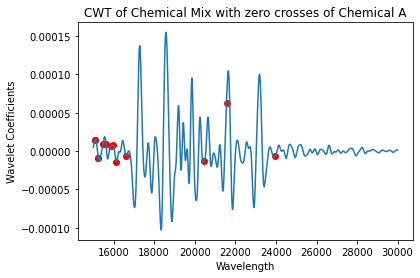

In [340]:
plt.plot(np.arange(15000,30000), cwt_mix_1d[15000:30000])
plt.scatter(a_roots, cwt_mix_1d[a_roots], c='red')
plt.xlabel("Wavelength")
plt.ylabel("Wavelet Coefficients")
plt.title("CWT of Chemical Mix with zero crosses of Chemical A");

In [310]:
# Find the wavelength such that the wavelet coefficient of chemical B is at its 
#  absolute maximum. This value is least likely to actually be zero.
lambda_0 = a_roots[np.argmax(abs(cwt_b_1d[a_roots]), axis=0)]
lambda_0

16131

In [312]:
# From this, determine C_{B} using the equations above.
cb = cwt_mix_1d[lambda_0]/cwt_b_1d[lambda_0]
cb

0.3761457215811484

In [342]:
# Now apply the same method to find the zeros of the wavelet transform of 
#  chemical B in order to find C_{A}. Note that we have to use a slightly 
#  larger tolerance else the finder will not return any zeroes.
b_roots = zero_finder(cwt_b_1d, 21500, 23000, tolerance=10**-6)

# Again compare the results of the function with actual value of coefficients.
b_roots, cwt_b_1d[b_roots]

([21748,
  21749,
  21750,
  22133,
  22134,
  22386,
  22387,
  22388,
  22641,
  22642,
  22643,
  22644,
  22645,
  22646,
  22774,
  22775,
  22776,
  22777,
  22778],
 array([ 8.65334475e-07,  2.17651483e-07, -4.28020983e-07, -1.83468104e-07,
         7.33297988e-07,  9.57686382e-07,  1.95484654e-07, -5.68683841e-07,
        -8.38081127e-07, -5.18560763e-07, -2.02563952e-07,  1.09902244e-07,
         4.18830392e-07,  7.24212643e-07,  9.69846679e-07,  5.84450478e-07,
         1.92703833e-07, -2.05348960e-07, -6.09660931e-07]))

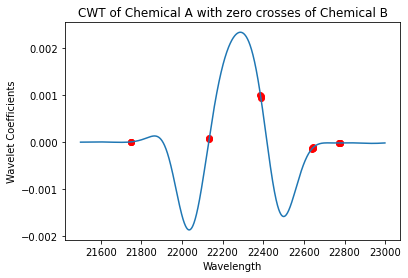

In [337]:
# Plot these on the continuous wavelet coefficient curve for Chemical A to 
#  make sure the corresponding coefficients are not zero either.
plt.plot(np.arange(21500,23000), cwt_a_1d[21500:23000])
plt.scatter(b_roots, cwt_a_1d[b_roots], c='red');
plt.xlabel("Wavelength")
plt.ylabel("Wavelet Coefficients")
plt.title("CWT of Chemical A with zero crosses of Chemical B");

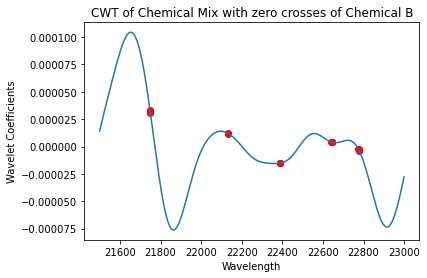

In [350]:
plt.plot(np.arange(21500,23000), cwt_mix_1d[21500:23000])
plt.scatter(b_roots, cwt_mix_1d[b_roots], c='red')
plt.xlabel("Wavelength")
plt.ylabel("Wavelet Coefficients")
plt.title("CWT of Chemical Mix with zero crosses of Chemical B");

In [348]:
# Find the wavelength such that wavelet coefficient of chemical A is at its 
#  absolute maximum.
lambda_1 = b_roots[np.argmax(abs(cwt_a_1d[b_roots]), axis=0)]
lambda_1

22386

In [349]:
# From this, determine C_{A} using the equations above.
ca = cwt_mix_1d[lambda_1]/cwt_a_1d[lambda_1]
ca

-0.01532558411964553

A negative result suggests that there is _**no contribution from chemical A in the mixture**_. If there were, the continuous wavelet transform of the chemical mixture would increase with increasing wavelet coefficients of chemical A, not the other way around!

Furthermore, given that the wavelet coefficient of the mixture is relatively non-trivial (i.e. larger than the tolerances used to calculate the zero crossings) as the wavelet coefficient of chemical B vanishes, it is likely that there is another component in the mixture which is neither chemical A nor chemical B.

## Conclusion

From our analysis of the spectra for chemicals A, B, and the mystery mixture, we have found:
- Chemical A is certainly not in the mixture.
- Chemical B is certainly in the mixture.
- It is likely that there are additional chemicals besides the two given.

More data must be given to properly classify the components of the mixture, primarily in the form of additional absorption spectra. From this, the composition of the mixture can be verified and the relative concentrations of the components can be computed from continuous wavelet transforms, up to a ternary mixture.

For more complicated mixtures, methods from blind signal composition can be implemented, such as independent component analysis, though, this requires chemists to prepare $n$ different mixtures with the same chemicals, of varying partial concentrations, for a mixture comprising of $n$ components.